In [47]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import IPython
from IPython.display import display

import io
import time
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import PIL
import cv2

import sneks
import gym

import torch
import torch.nn as nn

DEVICE = 'cuda'

In [49]:
env = gym.make('snek-rgb-16-v1')

observation = env.reset()
action = env.action_space.sample()
observation, reward, done, info = env.step(action)

env.action_space, env.observation_space

(Discrete(4), Box(16, 16, 3))

In [50]:
# https://github.com/NicksonYap/Jupyter-Webcam/blob/master/Realtime_video_ipython_py3.ipynb
def show_array(a, prev_display_id=None, fmt='jpeg'):
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    obj = IPython.display.Image(data=f.getvalue())
    IPython.display.display(obj)

In [260]:
def show_live_env(env, controller, fps=100):
    try:
        while True:
            f = 0
            obs = env.reset()
            while True:
                IPython.display.clear_output(wait=True)
                time.sleep(1 / fps)
                f += 1

                action = controller(f, obs)
                obs, _, done, _ = env.step(action)
                frame = env.render('rgb_array')
                show_array(frame)
                if done: break
    except KeyboardInterrupt:
        show_array(frame) # show last frame
        print('stream interrupted')

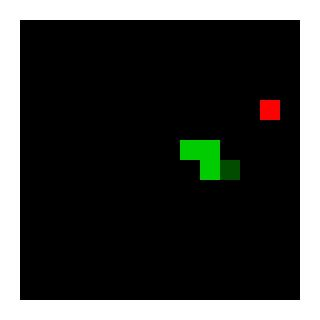

stream interrupted


In [262]:
def controller(f, obs):
    return env.action_space.sample()
    if done:
        raise KeyboardInterrupt()

show_live_env(env, controller)

In [254]:
obs_size = 16 * 16 * 3
num_actions = 4
hidden_dim = 512
discount = 0.5

def dense(i, o, a=nn.Sigmoid):
    l = nn.Linear(i, o)
#     l.weight.data = torch.normal(2, 2, (o, i))
#     l.bias.data = torch.normal(2, 2, (o,))
    return nn.Sequential(l, a())

class QNet(nn.Module):
    def __init__(self):
        super(QNet, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            dense(obs_size, hidden_dim, nn.ReLU),
            dense(hidden_dim, hidden_dim, nn.ReLU),
            dense(hidden_dim, hidden_dim, nn.ReLU),
            dense(hidden_dim, hidden_dim, nn.ReLU),
            dense(hidden_dim, hidden_dim, nn.ReLU),
            nn.Linear(hidden_dim, num_actions),
        ).to(DEVICE)

        self.criterion = nn.MSELoss().to(DEVICE)
        self.optimizer = torch.optim.Adam(params=self.parameters(), lr=0.001)
        
    def loss(self, batch):
        obs = [o / 255 for o, a, r in batch]

        next_obs = torch.tensor(
            [exp for o in obs for exp in o[1:]],
            dtype=torch.float32
        ).reshape(-1, obs_size).to(DEVICE)
        obs = torch.tensor(
            [exp for o in obs for exp in o[:-1]],
            dtype=torch.float32
        ).reshape(-1, obs_size).to(DEVICE)

        actions = torch.tensor(
            [a for _, actions, _ in batch for a in actions[1:]],
            dtype=torch.long
        ).reshape(-1).to(DEVICE)
        rewards = torch.tensor(
            [r for _, _, rewards in batch for r in rewards[1:]],
            dtype=torch.float32
        ).reshape(-1).to(DEVICE)
        
        with torch.no_grad():
            next_q_vals = self.net(next_obs).argmax(dim=1)
        
        q_vals = self.net(obs).index_select(dim=1, index=actions)[0]
        target_q_vals = next_q_vals * discount + rewards

        return self.criterion(q_vals, target_q_vals)

    def forward(self, obs):
        return self.net(obs)
        
    def get_max_action(self, obs):
        obs = torch.tensor(obs[np.newaxis, ...] / 255, dtype=torch.float32).to(DEVICE)
        q_vals = self.net(obs)[0]

        return q_vals.argmax().cpu().detach().numpy()


q_net = QNet()
# episode1 = play_episode(env, q_net)
# episode2 = play_episode(env, q_net)
# q_net.loss([episode1, episode2])

In [236]:
def q_net_controller(f, obs):
    return q_net.get_max_action(obs)

    if done:
        raise KeyboardInterrupt()

# show_live_env(env, q_net_controller)

In [237]:
def play_episode(env, model):
    max_rollout_steps = 100
    discount = 0.5
    ee_tradeoff = 0.5
    obs = env.reset()
    all_obs = []
    all_actions = []
    all_rewards = []

    for _ in range(max_rollout_steps):
        max_action = model.get_max_action(obs) \
                        if random.random() > ee_tradeoff else \
                     env.action_space.sample()

        obs, reward, done, info = env.step(max_action)
        all_obs.append(obs)
        all_actions.append(max_action)
        all_rewards.append(reward)
        if done: break

#     q_vals = [
#         sum([discount ** j * r for j, r in enumerate(all_rewards[i:])])
#         for i in range(len(all_rewards))
#     ]

    return (
        np.array(all_obs),
        np.array(all_actions),
        np.array(all_rewards),
    )

obs, actions, rewards = play_episode(env, q_net)
obs.shape, actions.shape, rewards.shape

((8, 16, 16, 3), (8,), (8,))

In [238]:
t = torch.tensor([1, 2, 3])

t[1:], t[:-1]

(tensor([2, 3]), tensor([1, 2]))

In [265]:
def dqn_optimize(env, model):
    experience_pool = []
    max_experiences = 5000
    its =  300
    bs = 64

    def optimization_step():
        batch = random.sample(experience_pool, min(len(experience_pool), bs))
        # batch = experience_pool[-bs:]

        model.optimizer.zero_grad()
        loss = model.loss(batch)
        loss.backward()
        model.optimizer.step()

        return loss.item()


    tr = trange(its, bar_format='{bar}{desc}')
    for i in tr:
        episode = play_episode(env, model)
        experience_pool.append(episode)

        loss = optimization_step()
        tr.set_description(
            'it %i/%i | Loss: %.6f | EP Size: %i' % 
            (i + 1, its, loss, len(experience_pool))
        )

        if len(experience_pool) > max_experiences:
            experience_pool = experience_pool[1:]

In [ ]:
dqn_optimize(env, q_net)

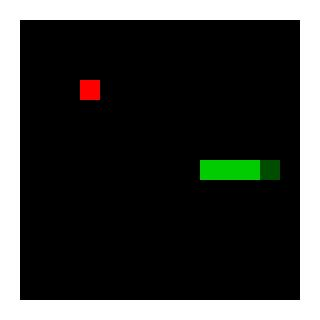

stream interrupted


In [270]:
show_live_env(env, q_net_controller, fps=10)